# BASE 1 - CI

Information:

* Database: base 1
* Predicted variable: Corrupción Intensa
* Type of prediction: Clasification
* Periodo: 2016-2020

## 1. Load data and Libraries

In [1]:
import warnings
warnings.filterwarnings( 'ignore' )

In [2]:
import pandas as  pd
import numpy as np
import pickle
import joblib
import matplotlib.pyplot as plt

In [3]:
path = r'..\..\..\input\preprocessed_data\base1.csv'
data = pd.read_csv( path )

In [4]:
data.shape

(2133, 14494)

In [5]:
data[ 'corrup_intensa' ].value_counts( normalize = True )*100

1.0    66.057196
0.0    33.942804
Name: corrup_intensa, dtype: float64

In [6]:
data[ 'corrup_intensa' ].value_counts()

1.0    1409
0.0     724
Name: corrup_intensa, dtype: int64

## 2. Split variables

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
dep_var    = [ 'corrup_intensa' ]
other_vars = [ 'monto_examinado', 'monto_auditado', 'monto_objeto_servicio', 
               'monto_corrup1', 'monto_corrup2', 'tipo_control', 'corrup_amplia',
               'per_corrup1', 'per_corrup2', '_monto', 'monto_', 'year', 'ubigeo' ]

pred_vars  = [ col for col in data.columns if col not in dep_var and col not in other_vars ]

x_train, x_test, y_train, y_test = train_test_split( data[ pred_vars ], 
                                                     data[ 'corrup_intensa' ], 
                                                     test_size    = 0.25,
                                                     random_state = 2023 )

## 3. Resampling

#### 3.1 SMOTE TOMEK

In [9]:
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from collections import Counter 

os_us = SMOTETomek( random_state         = 2023, 
                    sampling_strategy    = 'all' )

x_train_smote_tomek, y_train_smote_tomek = os_us.fit_resample( x_train, y_train )

#### 3.2 SMOTE

In [10]:
os_us = SMOTE( random_state      = 2023, 
               sampling_strategy = 'all' )

x_train_smote, y_train_smote = os_us.fit_resample( x_train, y_train )

#### 3.3 Naive random sampling

In [11]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler( random_state = 2023 )

x_train_ros, y_train_ros = ros.fit_resample( x_train, y_train )

### 3.4. Check data and variables percentage

In [12]:
check_data      = np.zeros( ( 4, 4 ) )

check_data[ 0 ] = [ x_train.shape[ 0 ], x_train.shape[ 1 ], 
                    y_train.value_counts()[ 0 ], y_train.value_counts()[ 1 ] ]

check_data[ 1 ] = [ x_train_smote.shape[ 0 ], x_train_smote.shape[ 1 ], 
                    y_train_smote.value_counts()[ 0 ], y_train_smote.value_counts()[ 1 ] ]

check_data[ 2 ] = [ x_train_smote_tomek.shape[ 0 ], x_train_smote_tomek.shape[ 1 ],
                    y_train_smote_tomek.value_counts()[ 0 ], y_train_smote_tomek.value_counts()[ 1 ] ]

check_data[ 3 ] = [ x_train_ros.shape[ 0 ], x_train_ros.shape[ 1 ],
                    y_train_ros.value_counts()[ 0 ], y_train_ros.value_counts()[ 1 ] ]

colnames        = [ 'observaciones', 'variables', 'Nro. No', 'Nro. Si' ]

rownames        = [ 'Original',
                    'SMOTE',
                    'SOMTE Tomek',
                    'NRS' ]

table_check_data = pd.DataFrame( check_data, columns = colnames )
table_check_data.index = rownames
table_check_data

,observaciones,variables,Nro. No,Nro. Si
Original,1599.0,14487.0,531.0,1068.0
SMOTE,2136.0,14487.0,1068.0,1068.0
SOMTE Tomek,1912.0,14487.0,956.0,956.0
NRS,2136.0,14487.0,1068.0,1068.0


In [13]:
# Calculate the percentage of variables to be included for the original dataset

o_20 = 20*x_train.shape[ 1 ]/100
o_30 = 30*x_train.shape[ 1 ]/100
o_40 = 40*x_train.shape[ 1 ]/100

print( o_20, o_30, o_40, sep = '\n' )

2897.4
4346.1
5794.8


## 4. Logistic Regression

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

In [15]:
%%time

# Implementing the model
lg_model_o          = LogisticRegression( random_state = 2023 ).fit( x_train, y_train )
lg_model_s          = LogisticRegression( random_state = 2023 ).fit( x_train_smote, y_train_smote )
lg_model_st         = LogisticRegression( random_state = 2023 ).fit( x_train_smote_tomek, y_train_smote_tomek )
lg_model_nrs        = LogisticRegression( random_state = 2023 ).fit( x_train_ros, y_train_ros )

# Predict over test set
y_lg_pred_class_o   = lg_model_o.predict( x_test )
y_lg_pred_prob_o    = lg_model_o.predict_proba( x_test )[ :, 1 ]

y_lg_pred_class_s   = lg_model_s.predict( x_test )
y_lg_pred_prob_s    = lg_model_s.predict_proba( x_test )[ :, 1 ]

y_lg_pred_class_st  = lg_model_st.predict( x_test )
y_lg_pred_prob_st   = lg_model_st.predict_proba( x_test )[ :, 1 ]

y_lg_pred_class_nrs = lg_model_nrs.predict( x_test )
y_lg_pred_prob_nrs  = lg_model_nrs.predict_proba( x_test )[ :, 1 ]

Wall time: 15.1 s


In [16]:
columns             = [ 'no', 'si' ]
lg_report_o         = classification_report( y_test, y_lg_pred_class_o, target_names = columns )
print( lg_report_o )

              precision    recall  f1-score   support

          no       0.54      0.19      0.28       193
          si       0.67      0.91      0.77       341

    accuracy                           0.65       534
   macro avg       0.60      0.55      0.53       534
weighted avg       0.62      0.65      0.59       534



In [ ]:
f1_score_lg_o       = f1_score( y_test, y_lg_pred_class_s, average = 'macro' )

In [16]:
# Calculating clasiffication report
columns             = [ 'no', 'si' ]
lg_report_o         = classification_report( y_test, y_lg_pred_class_o, target_names = columns, output_dict = True )
lg_report_s         = classification_report( y_test, y_lg_pred_class_s, target_names = columns, output_dict = True )
lg_report_st        = classification_report( y_test, y_lg_pred_class_st, target_names = columns, output_dict = True )
lg_report_nrs       = classification_report( y_test, y_lg_pred_class_nrs, target_names = columns, output_dict = True )

# Calculating metrics for the original model
lg_no_precision_o   = lg_report_o[ 'no' ][ 'precision' ]
lg_no_recall_o      = lg_report_o[ 'no' ][ 'recall' ]
lg_no_f1_score_o    = lg_report_o[ 'no' ][ 'f1-score' ]

lg_si_precision_o   = lg_report_o[ 'si' ][ 'precision' ]
lg_si_recall_o      = lg_report_o[ 'si' ][ 'recall' ]
lg_si_f1_score_o    = lg_report_o[ 'si' ][ 'f1-score' ]

accuracy_lg_o       = accuracy_score( y_test, y_lg_pred_class_o )
log_loss_lg_o       = log_loss( y_test, y_lg_pred_class_o )
roc_auc_lg_o        = roc_auc_score( y_test, y_lg_pred_prob_o )
f1_score_lg_o       = f1_score( y_test, y_lg_pred_class_s, average = 'macro' )

# Calculating metrics for the SMOTE model
lg_no_precision_s   = lg_report_s[ 'no' ][ 'precision' ]
lg_no_recall_s      = lg_report_s[ 'no' ][ 'recall' ]
lg_no_f1_score_s    = lg_report_s[ 'no' ][ 'f1-score' ]

lg_si_precision_s   = lg_report_s[ 'si' ][ 'precision' ]
lg_si_recall_s      = lg_report_s[ 'si' ][ 'recall' ]
lg_si_f1_score_s    = lg_report_s[ 'si' ][ 'f1-score' ]

accuracy_lg_s       = accuracy_score( y_test, y_lg_pred_class_s )
log_loss_lg_s       = log_loss( y_test, y_lg_pred_class_s )
roc_auc_lg_s        = roc_auc_score( y_test, y_lg_pred_prob_s )
f1_score_lg_s       = f1_score( y_test, y_lg_pred_class_s, average = 'macro' )

# Calculating metrics for the SMOTE Tomek model
lg_no_precision_st  = lg_report_st[ 'no' ][ 'precision' ]
lg_no_recall_st     = lg_report_st[ 'no' ][ 'recall' ]
lg_no_f1_score_st   = lg_report_st[ 'no' ][ 'f1-score' ]

lg_si_precision_st  = lg_report_st[ 'si' ][ 'precision' ]
lg_si_recall_st     = lg_report_st[ 'si' ][ 'recall' ]
lg_si_f1_score_st   = lg_report_st[ 'si' ][ 'f1-score' ]

accuracy_lg_st      = accuracy_score( y_test, y_lg_pred_class_st )
log_loss_lg_st      = log_loss( y_test, y_lg_pred_class_st )
roc_auc_lg_st       = roc_auc_score( y_test, y_lg_pred_prob_st )
f1_score_lg_st      = f1_score( y_test, y_lg_pred_class_st, average = 'macro' )

# Calculating metrics for the NRS model
lg_no_precision_nrs = lg_report_st[ 'no' ][ 'precision' ]
lg_no_recall_nrs    = lg_report_st[ 'no' ][ 'recall' ]
lg_no_f1_score_nrs  = lg_report_st[ 'no' ][ 'f1-score' ]

lg_si_precision_nrs = lg_report_st[ 'si' ][ 'precision' ]
lg_si_recall_nrs    = lg_report_st[ 'si' ][ 'recall' ]
lg_si_f1_score_nrs  = lg_report_st[ 'si' ][ 'f1-score' ]

accuracy_lg_nrs     = accuracy_score( y_test, y_lg_pred_class_nrs )
log_loss_lg_nrs     = log_loss( y_test, y_lg_pred_class_nrs )
roc_auc_lg_nrs      = roc_auc_score( y_test, y_lg_pred_prob_nrs )
f1_score_lg_nrs     = f1_score( y_test, y_lg_pred_class_nrs, average = 'macro' )

## 5. Regularization Methods (Lasso, Ridge and Elastic Net)

In [17]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import GridSearchCV

## 5.1. Lasso

In [18]:
%%time

# Implementing the model
lasso_model_o          = LogisticRegressionCV( penalty = 'l1', solver = 'saga', cv = 10, random_state = 2023, n_jobs = -1 ).\
                                          fit( x_train, y_train )

lasso_model_s          = LogisticRegressionCV( penalty = 'l1', solver = 'saga', cv = 10, random_state = 2023, n_jobs = -1 ).\
                                          fit( x_train_smote, y_train_smote )

lasso_model_st         = LogisticRegressionCV( penalty = 'l1', solver = 'saga', cv = 10, random_state = 2023, n_jobs = -1 ).\
                                          fit( x_train_smote_tomek, y_train_smote_tomek )

lasso_model_nrs        = LogisticRegressionCV( penalty = 'l1', solver = 'saga', cv = 10, random_state = 2023, n_jobs = -1 ).\
                                          fit( x_train_ros, y_train_ros )

# Predict over test set
y_lasso_pred_class_o   = lasso_model_o.predict( x_test )
y_lasso_pred_prob_o    = lasso_model_o.predict_proba( x_test )[ :, 1 ]

y_lasso_pred_class_s   = lasso_model_s.predict( x_test )
y_lasso_pred_prob_s    = lasso_model_s.predict_proba( x_test )[ :, 1 ]

y_lasso_pred_class_st  = lasso_model_st.predict( x_test )
y_lasso_pred_prob_st   = lasso_model_st.predict_proba( x_test )[ :, 1 ]

y_lasso_pred_class_nrs = lasso_model_nrs.predict( x_test )
y_lasso_pred_prob_nrs  = lasso_model_nrs.predict_proba( x_test )[ :, 1 ]

Wall time: 2h 48min 34s


In [19]:
# Calculating clasiffication report
columns                = [ 'no', 'si' ]
lasso_report_o         = classification_report( y_test, y_lasso_pred_class_o, target_names = columns, output_dict = True )
lasso_report_s         = classification_report( y_test, y_lasso_pred_class_s, target_names = columns, output_dict = True )
lasso_report_st        = classification_report( y_test, y_lasso_pred_class_st, target_names = columns, output_dict = True )
lasso_report_nrs       = classification_report( y_test, y_lasso_pred_class_nrs, target_names = columns, output_dict = True )

# Calculating metrics for the original model
lasso_no_precision_o   = lasso_report_o[ 'no' ][ 'precision' ]
lasso_no_recall_o      = lasso_report_o[ 'no' ][ 'recall' ]
lasso_no_f1_score_o    = lasso_report_o[ 'no' ][ 'f1-score' ]

lasso_si_precision_o   = lasso_report_o[ 'si' ][ 'precision' ]
lasso_si_recall_o      = lasso_report_o[ 'si' ][ 'recall' ]
lasso_si_f1_score_o    = lasso_report_o[ 'si' ][ 'f1-score' ]

accuracy_lasso_o       = accuracy_score( y_test, y_lasso_pred_class_o )
log_loss_lasso_o       = log_loss( y_test, y_lasso_pred_class_o )
roc_auc_lasso_o        = roc_auc_score( y_test, y_lasso_pred_prob_o )
f1_score_lasso_o       = f1_score( y_test, y_lasso_pred_class_o, average = 'macro' )

# Calculating metrics for the SMOTE model
lasso_no_precision_s   = lasso_report_s[ 'no' ][ 'precision' ]
lasso_no_recall_s      = lasso_report_s[ 'no' ][ 'recall' ]
lasso_no_f1_score_s    = lasso_report_s[ 'no' ][ 'f1-score' ]

lasso_si_precision_s   = lasso_report_s[ 'si' ][ 'precision' ]
lasso_si_recall_s      = lasso_report_s[ 'si' ][ 'recall' ]
lasso_si_f1_score_s    = lasso_report_s[ 'si' ][ 'f1-score' ]

accuracy_lasso_s       = accuracy_score( y_test, y_lasso_pred_class_s )
log_loss_lasso_s       = log_loss( y_test, y_lasso_pred_class_s )
roc_auc_lasso_s        = roc_auc_score( y_test, y_lasso_pred_prob_s )
f1_score_lasso_s       = f1_score( y_test, y_lasso_pred_class_s, average = 'macro' )

# Calculating metrics for the SMOTE Tomek model
lasso_no_precision_st  = lasso_report_st[ 'no' ][ 'precision' ]
lasso_no_recall_st     = lasso_report_st[ 'no' ][ 'recall' ]
lasso_no_f1_score_st   = lasso_report_st[ 'no' ][ 'f1-score' ]

lasso_si_precision_st  = lasso_report_st[ 'si' ][ 'precision' ]
lasso_si_recall_st     = lasso_report_st[ 'si' ][ 'recall' ]
lasso_si_f1_score_st   = lasso_report_st[ 'si' ][ 'f1-score' ]

accuracy_lasso_st      = accuracy_score( y_test, y_lasso_pred_class_st )
log_loss_lasso_st      = log_loss( y_test, y_lasso_pred_class_st )
roc_auc_lasso_st       = roc_auc_score( y_test, y_lasso_pred_prob_st )
f1_score_lasso_st      = f1_score( y_test, y_lasso_pred_class_st, average = 'macro' )

# Calculating metrics for the NRS model
lasso_no_precision_nrs = lasso_report_nrs[ 'no' ][ 'precision' ]
lasso_no_recall_nrs    = lasso_report_nrs[ 'no' ][ 'recall' ]
lasso_no_f1_score_nrs  = lasso_report_nrs[ 'no' ][ 'f1-score' ]

lasso_si_precision_nrs = lasso_report_nrs[ 'si' ][ 'precision' ]
lasso_si_recall_nrs    = lasso_report_nrs[ 'si' ][ 'recall' ]
lasso_si_f1_score_nrs  = lasso_report_nrs[ 'si' ][ 'f1-score' ]

accuracy_lasso_nrs     = accuracy_score( y_test, y_lasso_pred_class_nrs )
log_loss_lasso_nrs     = log_loss( y_test, y_lasso_pred_class_nrs )
roc_auc_lasso_nrs      = roc_auc_score( y_test, y_lasso_pred_prob_nrs )
f1_score_lasso_nrs     = f1_score( y_test, y_lasso_pred_class_nrs, average = 'macro' )

In [20]:
# coef_series = pd.DataFrame( data = lasso_model_o.coef_.reshape(-1, 1), index = lasso_model_o.feature_names_in_ )
# a = coef_series.sort_values(by=0, ascending = False, key = abs )
# a.to_excel('a.xlsx')

## 5.2. Ridge

In [21]:
%%time

# Implementing the model
ridge_model_o          = LogisticRegressionCV( penalty = 'l2', solver = 'saga', cv = 10, random_state = 2023, n_jobs = -1 ).\
                                          fit( x_train, y_train )

ridge_model_s          = LogisticRegressionCV( penalty = 'l2', solver = 'saga', cv = 10, random_state = 2023, n_jobs = -1 ).\
                                          fit( x_train_smote, y_train_smote )

ridge_model_st         = LogisticRegressionCV( penalty = 'l2', solver = 'saga', cv = 10, random_state = 2023, n_jobs = -1 ).\
                                          fit( x_train_smote_tomek, y_train_smote_tomek )

ridge_model_nrs        = LogisticRegressionCV( penalty = 'l2', solver = 'saga', cv = 10, random_state = 2023, n_jobs = -1 ).\
                                          fit( x_train_ros, y_train_ros )

# Predict over test set
y_ridge_pred_class_o   = ridge_model_o.predict( x_test )
y_ridge_pred_prob_o    = ridge_model_o.predict_proba( x_test )[ :, 1 ]

y_ridge_pred_class_s   = ridge_model_s.predict( x_test )
y_ridge_pred_prob_s    = ridge_model_s.predict_proba( x_test )[ :, 1 ]

y_ridge_pred_class_st  = ridge_model_st.predict( x_test )
y_ridge_pred_prob_st   = ridge_model_st.predict_proba( x_test )[ :, 1 ]

y_ridge_pred_class_nrs = ridge_model_nrs.predict( x_test )
y_ridge_pred_prob_nrs  = ridge_model_nrs.predict_proba( x_test )[ :, 1 ]

Wall time: 1h 39min 41s


In [22]:
# Calculating clasiffication report
columns                = [ 'no', 'si' ]
ridge_report_o         = classification_report( y_test, y_ridge_pred_class_o, target_names = columns, output_dict = True )
ridge_report_s         = classification_report( y_test, y_ridge_pred_class_s, target_names = columns, output_dict = True )
ridge_report_st        = classification_report( y_test, y_ridge_pred_class_st, target_names = columns, output_dict = True )
ridge_report_nrs       = classification_report( y_test, y_ridge_pred_class_nrs, target_names = columns, output_dict = True )

# Calculating metrics for the original model
ridge_no_precision_o   = ridge_report_o[ 'no' ][ 'precision' ]
ridge_no_recall_o      = ridge_report_o[ 'no' ][ 'recall' ]
ridge_no_f1_score_o    = ridge_report_o[ 'no' ][ 'f1-score' ]

ridge_si_precision_o   = ridge_report_o[ 'si' ][ 'precision' ]
ridge_si_recall_o      = ridge_report_o[ 'si' ][ 'recall' ]
ridge_si_f1_score_o    = ridge_report_o[ 'si' ][ 'f1-score' ]

accuracy_ridge_o       = accuracy_score( y_test, y_ridge_pred_class_o )
log_loss_ridge_o       = log_loss( y_test, y_ridge_pred_class_o )
roc_auc_ridge_o        = roc_auc_score( y_test, y_ridge_pred_prob_o )
f1_score_ridge_o       = f1_score( y_test, y_ridge_pred_class_o, average = 'macro' )

# Calculating metrics for the SMOTE model
ridge_no_precision_s   = ridge_report_s[ 'no' ][ 'precision' ]
ridge_no_recall_s      = ridge_report_s[ 'no' ][ 'recall' ]
ridge_no_f1_score_s    = ridge_report_s[ 'no' ][ 'f1-score' ]

ridge_si_precision_s   = ridge_report_s[ 'si' ][ 'precision' ]
ridge_si_recall_s      = ridge_report_s[ 'si' ][ 'recall' ]
ridge_si_f1_score_s    = ridge_report_s[ 'si' ][ 'f1-score' ]

accuracy_ridge_s       = accuracy_score( y_test, y_ridge_pred_class_s )
log_loss_ridge_s       = log_loss( y_test, y_ridge_pred_class_s )
roc_auc_ridge_s        = roc_auc_score( y_test, y_ridge_pred_prob_s )
f1_score_ridge_s       = f1_score( y_test, y_ridge_pred_class_s, average = 'macro' )

# Calculating metrics for the SMOTE Tomek model
ridge_no_precision_st  = ridge_report_st[ 'no' ][ 'precision' ]
ridge_no_recall_st     = ridge_report_st[ 'no' ][ 'recall' ]
ridge_no_f1_score_st   = ridge_report_st[ 'no' ][ 'f1-score' ]

ridge_si_precision_st  = ridge_report_st[ 'si' ][ 'precision' ]
ridge_si_recall_st     = ridge_report_st[ 'si' ][ 'recall' ]
ridge_si_f1_score_st   = ridge_report_st[ 'si' ][ 'f1-score' ]

accuracy_ridge_st      = accuracy_score( y_test, y_ridge_pred_class_st )
log_loss_ridge_st      = log_loss( y_test, y_ridge_pred_class_st )
roc_auc_ridge_st       = roc_auc_score( y_test, y_ridge_pred_prob_st )
f1_score_ridge_st      = f1_score( y_test, y_ridge_pred_class_st, average = 'macro' )

# Calculating metrics for the NRS model
ridge_no_precision_nrs = ridge_report_nrs[ 'no' ][ 'precision' ]
ridge_no_recall_nrs    = ridge_report_nrs[ 'no' ][ 'recall' ]
ridge_no_f1_score_nrs  = ridge_report_nrs[ 'no' ][ 'f1-score' ]

ridge_si_precision_nrs = ridge_report_nrs[ 'si' ][ 'precision' ]
ridge_si_recall_nrs    = ridge_report_nrs[ 'si' ][ 'recall' ]
ridge_si_f1_score_nrs  = ridge_report_nrs[ 'si' ][ 'f1-score' ]

accuracy_ridge_nrs     = accuracy_score( y_test, y_ridge_pred_class_nrs )
log_loss_ridge_nrs     = log_loss( y_test, y_ridge_pred_class_nrs )
roc_auc_ridge_nrs      = roc_auc_score( y_test, y_ridge_pred_prob_nrs )
f1_score_ridge_nrs     = f1_score( y_test, y_ridge_pred_class_nrs, average = 'macro' )

### 5.3. Elastic Net

In [23]:
%%time

# Implementing the model
elasticnet_model_o          = LogisticRegressionCV( penalty = 'elasticnet', solver = 'saga', cv = 10, random_state = 2023, l1_ratios = [ 0.5 ], n_jobs = -1 ).\
                                               fit( x_train, y_train )

elasticnet_model_s          = LogisticRegressionCV( penalty = 'elasticnet', solver = 'saga', cv = 10, random_state = 2023, l1_ratios = [ 0.5 ], n_jobs = -1 ).\
                                               fit( x_train_smote, y_train_smote )

elasticnet_model_st         = LogisticRegressionCV( penalty = 'elasticnet', solver = 'saga', cv = 10, random_state = 2023, l1_ratios = [ 0.5 ], n_jobs = -1 ).\
                                               fit( x_train_smote_tomek, y_train_smote_tomek )

elasticnet_model_nrs        = LogisticRegressionCV( penalty = 'elasticnet', solver = 'saga', cv = 10, random_state = 2023, l1_ratios = [ 0.5 ], n_jobs = -1 ).\
                                               fit( x_train_ros, y_train_ros )


# Predict over test set
y_elasticnet_pred_class_o   = elasticnet_model_o.predict( x_test )
y_elasticnet_pred_prob_o    = elasticnet_model_o.predict_proba( x_test )[ :, 1 ]

y_elasticnet_pred_class_s   = elasticnet_model_s.predict( x_test )
y_elasticnet_pred_prob_s    = elasticnet_model_s.predict_proba( x_test )[ :, 1 ]

y_elasticnet_pred_class_st  = elasticnet_model_st.predict( x_test )
y_elasticnet_pred_prob_st   = elasticnet_model_st.predict_proba( x_test )[ :, 1 ]

y_elasticnet_pred_class_nrs = elasticnet_model_nrs.predict( x_test )
y_elasticnet_pred_prob_nrs  = elasticnet_model_nrs.predict_proba( x_test )[ :, 1 ]

Wall time: 2h 43min 48s


In [24]:
# Calculating clasiffication report
columns                     = [ 'no', 'si' ]
elasticnet_report_o         = classification_report( y_test, y_elasticnet_pred_class_o, target_names = columns, output_dict = True )
elasticnet_report_s         = classification_report( y_test, y_elasticnet_pred_class_s, target_names = columns, output_dict = True )
elasticnet_report_st        = classification_report( y_test, y_elasticnet_pred_class_st, target_names = columns, output_dict = True )
elasticnet_report_nrs       = classification_report( y_test, y_elasticnet_pred_class_nrs, target_names = columns, output_dict = True )

# Calculating metrics for the original model
elasticnet_no_precision_o   = elasticnet_report_o[ 'no' ][ 'precision' ]
elasticnet_no_recall_o      = elasticnet_report_o[ 'no' ][ 'recall' ]
elasticnet_no_f1_score_o    = elasticnet_report_o[ 'no' ][ 'f1-score' ]

elasticnet_si_precision_o   = elasticnet_report_o[ 'si' ][ 'precision' ]
elasticnet_si_recall_o      = elasticnet_report_o[ 'si' ][ 'recall' ]
elasticnet_si_f1_score_o    = elasticnet_report_o[ 'si' ][ 'f1-score' ]

accuracy_elasticnet_o       = accuracy_score( y_test, y_elasticnet_pred_class_o )
log_loss_elasticnet_o       = log_loss( y_test, y_elasticnet_pred_class_o )
roc_auc_elasticnet_o        = roc_auc_score( y_test, y_elasticnet_pred_prob_o )
f1_score_elasticnet_o       = f1_score( y_test, y_elasticnet_pred_class_o, average = 'macro' )

# Calculating metrics for the SMOTE model
elasticnet_no_precision_s   = elasticnet_report_s[ 'no' ][ 'precision' ]
elasticnet_no_recall_s      = elasticnet_report_s[ 'no' ][ 'recall' ]
elasticnet_no_f1_score_s    = elasticnet_report_s[ 'no' ][ 'f1-score' ]

elasticnet_si_precision_s   = elasticnet_report_s[ 'si' ][ 'precision' ]
elasticnet_si_recall_s      = elasticnet_report_s[ 'si' ][ 'recall' ]
elasticnet_si_f1_score_s    = elasticnet_report_s[ 'si' ][ 'f1-score' ]

accuracy_elasticnet_s       = accuracy_score( y_test, y_elasticnet_pred_class_s )
log_loss_elasticnet_s       = log_loss( y_test, y_elasticnet_pred_class_s )
roc_auc_elasticnet_s        = roc_auc_score( y_test, y_elasticnet_pred_prob_s )
f1_score_elasticnet_s       = f1_score( y_test, y_elasticnet_pred_class_s, average = 'macro' )

# Calculating metrics for the SMOTE Tomek model
elasticnet_no_precision_st  = elasticnet_report_st[ 'no' ][ 'precision' ]
elasticnet_no_recall_st     = elasticnet_report_st[ 'no' ][ 'recall' ]
elasticnet_no_f1_score_st   = elasticnet_report_st[ 'no' ][ 'f1-score' ]

elasticnet_si_precision_st  = elasticnet_report_st[ 'si' ][ 'precision' ]
elasticnet_si_recall_st     = elasticnet_report_st[ 'si' ][ 'recall' ]
elasticnet_si_f1_score_st   = elasticnet_report_st[ 'si' ][ 'f1-score' ]

accuracy_elasticnet_st      = accuracy_score( y_test, y_elasticnet_pred_class_st )
log_loss_elasticnet_st      = log_loss( y_test, y_elasticnet_pred_class_st )
roc_auc_elasticnet_st       = roc_auc_score( y_test, y_elasticnet_pred_prob_st )
f1_score_elasticnet_st      = f1_score( y_test, y_elasticnet_pred_class_st, average = 'macro' )

# Calculating metrics for the NRS model
elasticnet_no_precision_nrs = elasticnet_report_nrs[ 'no' ][ 'precision' ]
elasticnet_no_recall_nrs    = elasticnet_report_nrs[ 'no' ][ 'recall' ]
elasticnet_no_f1_score_nrs  = elasticnet_report_nrs[ 'no' ][ 'f1-score' ]

elasticnet_si_precision_nrs = elasticnet_report_nrs[ 'si' ][ 'precision' ]
elasticnet_si_recall_nrs    = elasticnet_report_nrs[ 'si' ][ 'recall' ]
elasticnet_si_f1_score_nrs  = elasticnet_report_nrs[ 'si' ][ 'f1-score' ]

accuracy_elasticnet_nrs     = accuracy_score( y_test, y_elasticnet_pred_class_nrs )
log_loss_elasticnet_nrs     = log_loss( y_test, y_elasticnet_pred_class_nrs )
roc_auc_elasticnet_nrs      = roc_auc_score( y_test, y_elasticnet_pred_prob_nrs )
f1_score_elasticnet_nrs     = f1_score( y_test, y_elasticnet_pred_class_nrs, average = 'macro' )

## 6. Random Forest

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

In [26]:
%%time

# Set the model (Comentado)
rf_model = RandomForestClassifier( random_state = 2023,
                                   n_jobs = -1 )

# Define param grid (Comentado)
rf_param_grid = {
    'n_estimators': [ 250, 500, 1000 ],
    'max_features': [ 2903, 4355, 5806 ],
    'max_depth': [ 10, 20, 30 ]
}

# Set up cross-validation strategy
cv = KFold( n_splits = 5, shuffle = True, random_state = 2023 )

# Grid search (Comentado)
rf_search_o = GridSearchCV( estimator = rf_model,
                            param_grid = rf_param_grid,
                            cv = cv,
                            n_jobs = -1 )

rf_search_s = GridSearchCV( estimator = rf_model,
                            param_grid = rf_param_grid,
                            cv = cv,
                            n_jobs = -1 )

rf_search_st = GridSearchCV( estimator = rf_model,
                             param_grid = rf_param_grid,
                             cv = cv,
                             n_jobs = -1 )

rf_search_nrs = GridSearchCV( estimator = rf_model,
                              param_grid = rf_param_grid,
                              cv = cv,
                              n_jobs = -1 )

# Fit different models (Comentado)
rf_search_o.fit( x_train, y_train )
rf_search_s.fit( x_train_smote, y_train_smote )
rf_search_st.fit( x_train_smote_tomek, y_train_smote_tomek )
rf_search_nrs.fit( x_train_ros, y_train_ros )

# Print best params and best score (Comentado)
print( f'Original dataset: { rf_search_o.best_params_ }' )
print( f'SMOTE dataset: { rf_search_s.best_params_ }' )
print( f'SMOTE Tomek dataset: { rf_search_st.best_params_ }' )
print( f'NRS dataset: { rf_search_nrs.best_params_ }' )

# Select best params (Comentado)
rf_max_features_o   = rf_search_o.best_params_[ 'max_features' ] 
rf_n_estimators_o   = rf_search_o.best_params_[ 'n_estimators' ]
rf_max_depth_o      = rf_search_o.best_params_[ 'max_depth' ] 

rf_max_features_s   = rf_search_s.best_params_[ 'max_features' ] 
rf_n_estimators_s   = rf_search_s.best_params_[ 'n_estimators' ]
rf_max_depth_s      = rf_search_s.best_params_[ 'max_depth' ] 

rf_max_features_st  = rf_search_st.best_params_[ 'max_features' ] 
rf_n_estimators_st  = rf_search_st.best_params_[ 'n_estimators' ] 
rf_max_depth_st     = rf_search_st.best_params_[ 'max_depth' ] 

rf_max_features_nrs = rf_search_nrs.best_params_[ 'max_features' ] 
rf_n_estimators_nrs = rf_search_nrs.best_params_[ 'n_estimators' ]
rf_max_depth_nrs    = rf_search_nrs.best_params_[ 'max_depth' ] 

Original dataset: {'max_depth': 20, 'max_features': 2903, 'n_estimators': 1000}
SMOTE dataset: {'max_depth': 20, 'max_features': 4355, 'n_estimators': 250}
SMOTE Tomek dataset: {'max_depth': 20, 'max_features': 4355, 'n_estimators': 250}
NRS dataset: {'max_depth': 30, 'max_features': 5806, 'n_estimators': 250}
Wall time: 1d 9h 43min 7s


In [27]:
# Train the optimal models
rf_optimal_model_o = RandomForestClassifier( max_features = rf_max_features_o, 
                                             n_estimators = rf_n_estimators_o,
                                             max_depth    = rf_max_depth_o,                                             
                                             random_state = 2023,
                                             n_jobs = -1 )

rf_optimal_model_s = RandomForestClassifier( max_features = rf_max_features_s, 
                                             n_estimators = rf_n_estimators_s,
                                             max_depth    = rf_n_estimators_s,                                               
                                             random_state = 2023,
                                             n_jobs = -1 )

rf_optimal_model_st = RandomForestClassifier( max_features = rf_max_features_st, 
                                              n_estimators = rf_n_estimators_st,
                                              max_depth    = rf_n_estimators_st,
                                              random_state = 2023,
                                              n_jobs = -1 )

rf_optimal_model_nrs = RandomForestClassifier( max_features = rf_max_features_nrs, 
                                               n_estimators = rf_n_estimators_nrs,
                                               max_depth    = rf_n_estimators_nrs,
                                               random_state = 2023,
                                               n_jobs = -1 )

rf_optimal_model_o.fit( x_train, y_train )
rf_optimal_model_s.fit( x_train_smote, y_train_smote )
rf_optimal_model_st.fit( x_train_smote_tomek, y_train_smote_tomek )
rf_optimal_model_nrs.fit( x_train_ros, y_train_ros )

# Apply over test set
y_rf_pred_class_o   = rf_optimal_model_o.predict( x_test )
y_rf_pred_prob_o    = rf_optimal_model_o.predict_proba( x_test )[ :, 1 ]

y_rf_pred_class_s   = rf_optimal_model_s.predict( x_test )
y_rf_pred_prob_s    = rf_optimal_model_s.predict_proba( x_test )[ :, 1 ]

y_rf_pred_class_st  = rf_optimal_model_st.predict( x_test )
y_rf_pred_prob_st   = rf_optimal_model_st.predict_proba( x_test )[ :, 1 ]

y_rf_pred_class_nrs = rf_optimal_model_nrs.predict( x_test )
y_rf_pred_prob_nrs  = rf_optimal_model_nrs.predict_proba( x_test )[ :, 1 ]

In [28]:
# Calculating clasiffication report
columns             = [ 'no', 'si' ]
rf_report_o         = classification_report( y_test, y_rf_pred_class_o, target_names = columns, output_dict = True )
rf_report_s         = classification_report( y_test, y_rf_pred_class_s, target_names = columns, output_dict = True )
rf_report_st        = classification_report( y_test, y_rf_pred_class_st, target_names = columns, output_dict = True )
rf_report_nrs       = classification_report( y_test, y_rf_pred_class_nrs, target_names = columns, output_dict = True )

# Calculating metrics for the original model
rf_no_precision_o   = rf_report_o[ 'no' ][ 'precision' ]
rf_no_recall_o      = rf_report_o[ 'no' ][ 'recall' ]
rf_no_f1_score_o    = rf_report_o[ 'no' ][ 'f1-score' ]

rf_si_precision_o   = rf_report_o[ 'si' ][ 'precision' ]
rf_si_recall_o      = rf_report_o[ 'si' ][ 'recall' ]
rf_si_f1_score_o    = rf_report_o[ 'si' ][ 'f1-score' ]

accuracy_rf_o       = accuracy_score( y_test, y_rf_pred_class_o )
log_loss_rf_o       = log_loss( y_test, y_rf_pred_class_o )
roc_auc_rf_o        = roc_auc_score( y_test, y_rf_pred_prob_o )
f1_score_rf_o       = f1_score( y_test, y_rf_pred_class_o, average = 'macro' )

# Calculating metrics for the SMOTE model
rf_no_precision_s   = rf_report_s[ 'no' ][ 'precision' ]
rf_no_recall_s      = rf_report_s[ 'no' ][ 'recall' ]
rf_no_f1_score_s    = rf_report_s[ 'no' ][ 'f1-score' ]

rf_si_precision_s   = rf_report_s[ 'si' ][ 'precision' ]
rf_si_recall_s      = rf_report_s[ 'si' ][ 'recall' ]
rf_si_f1_score_s    = rf_report_s[ 'si' ][ 'f1-score' ]

accuracy_rf_s       = accuracy_score( y_test, y_rf_pred_class_s )
log_loss_rf_s       = log_loss( y_test, y_rf_pred_class_s )
roc_auc_rf_s        = roc_auc_score( y_test, y_rf_pred_prob_s )
f1_score_rf_s       = f1_score( y_test, y_rf_pred_class_s, average = 'macro' )

# Calculating metrics for the SMOTE Tomek model
rf_no_precision_st  = rf_report_st[ 'no' ][ 'precision' ]
rf_no_recall_st     = rf_report_st[ 'no' ][ 'recall' ]
rf_no_f1_score_st   = rf_report_st[ 'no' ][ 'f1-score' ]

rf_si_precision_st  = rf_report_st[ 'si' ][ 'precision' ]
rf_si_recall_st     = rf_report_st[ 'si' ][ 'recall' ]
rf_si_f1_score_st   = rf_report_st[ 'si' ][ 'f1-score' ]

accuracy_rf_st      = accuracy_score( y_test, y_rf_pred_class_st )
log_loss_rf_st      = log_loss( y_test, y_rf_pred_class_st )
roc_auc_rf_st       = roc_auc_score( y_test, y_rf_pred_prob_st )
f1_score_rf_st      = f1_score( y_test, y_rf_pred_class_st, average = 'macro' )

# Calculating metrics for the NRS model
rf_no_precision_nrs = rf_report_nrs[ 'no' ][ 'precision' ]
rf_no_recall_nrs    = rf_report_nrs[ 'no' ][ 'recall' ]
rf_no_f1_score_nrs  = rf_report_nrs[ 'no' ][ 'f1-score' ]

rf_si_precision_nrs = rf_report_nrs[ 'si' ][ 'precision' ]
rf_si_recall_nrs    = rf_report_nrs[ 'si' ][ 'recall' ]
rf_si_f1_score_nrs  = rf_report_nrs[ 'si' ][ 'f1-score' ]

accuracy_rf_nrs     = accuracy_score( y_test, y_rf_pred_class_nrs )
log_loss_rf_nrs     = log_loss( y_test, y_rf_pred_class_nrs )
roc_auc_rf_nrs      = roc_auc_score( y_test, y_rf_pred_prob_nrs )
f1_score_rf_nrs     = f1_score( y_test, y_rf_pred_class_nrs, average = 'macro' )

## 7. Boosted Trees

In [29]:
from xgboost import XGBClassifier

In [30]:
%%time

# Set the model (Comentrario) 
xgb_model = XGBClassifier( use_label_encoder = False, 
                           objective = 'binary:logistic', 
                           verbosity = 0,
                           learning_rate = 0.1,
                           random_state = 2023,
                           n_jobs = -1 )

# Define param grid (Comentrario)
xgb_param_grid = {
    'n_estimators': [ 250, 500, 1000 ],
    'max_features': [ 2903, 4355, 5806 ],
    'max_depth': [ 1, 2 ]
}

# Set up cross-validation strategy
cv = KFold( n_splits = 5, shuffle = True, random_state = 2023 )

# Grid search (Comentrario)
xgb_search_o = GridSearchCV( estimator = xgb_model,
                             param_grid = xgb_param_grid,
                             cv = cv,
                             n_jobs = -1 )

xgb_search_s = GridSearchCV( estimator = xgb_model,
                             param_grid = xgb_param_grid,
                             cv = cv,
                             n_jobs = -1 )

xgb_search_st = GridSearchCV( estimator = xgb_model,
                              param_grid = xgb_param_grid,
                              cv = cv,
                              n_jobs = -1 )

xgb_search_nrs = GridSearchCV( estimator = xgb_model,
                               param_grid = xgb_param_grid,
                               cv = cv,
                               n_jobs = -1 )

# Fit different models (Comentrario)
xgb_search_o.fit( x_train, y_train )
xgb_search_s.fit( x_train_smote, y_train_smote )
xgb_search_st.fit( x_train_smote_tomek, y_train_smote_tomek )
xgb_search_nrs.fit( x_train_ros, y_train_ros )

# Print best params and best scores (Comentrario)
print( xgb_search_o.best_params_ )
print( xgb_search_s.best_params_ )
print( xgb_search_st.best_params_ )
print( xgb_search_nrs.best_params_ )

# Select best params (Comentrario)
xgb_max_features_o   = xgb_search_o.best_params_[ 'max_features' ] 
xgb_max_depth_o      = xgb_search_o.best_params_[ 'max_depth' ] 
xgb_n_estimators_o   = xgb_search_o.best_params_[ 'n_estimators' ] 

xgb_max_features_s   = xgb_search_s.best_params_[ 'max_features' ] 
xgb_max_depth_s      = xgb_search_s.best_params_[ 'max_depth' ] 
xgb_n_estimators_s   = xgb_search_s.best_params_[ 'n_estimators' ] 

xgb_max_features_st  = xgb_search_st.best_params_[ 'max_features' ] 
xgb_max_depth_st     = xgb_search_st.best_params_[ 'max_depth' ] 
xgb_n_estimators_st  = xgb_search_st.best_params_[ 'n_estimators' ] 

xgb_max_features_nrs = xgb_search_nrs.best_params_[ 'max_features' ] 
xgb_max_depth_nrs    = xgb_search_nrs.best_params_[ 'max_depth' ] 
xgb_n_estimators_nrs = xgb_search_nrs.best_params_[ 'n_estimators' ]

{'max_depth': 1, 'max_features': 2903, 'n_estimators': 250}
{'max_depth': 2, 'max_features': 2903, 'n_estimators': 500}
{'max_depth': 2, 'max_features': 2903, 'n_estimators': 500}
{'max_depth': 2, 'max_features': 2903, 'n_estimators': 1000}
Wall time: 1d 4h 40min 17s


In [31]:
# Train the optimal model
xgb_optimal_model_o = XGBClassifier( objective = 'binary:logistic', 
                                     verbosity = 0,
                                     learning_rate = 0.1,
                                     max_features = xgb_max_features_o,
                                     max_depth = xgb_max_depth_o,
                                     n_estimators = xgb_n_estimators_o,
                                     random_state = 2023,
                                     n_jobs = -1 )

xgb_optimal_model_s = XGBClassifier( objective = 'binary:logistic', 
                                     verbosity = 0,
                                     learning_rate = 0.1,
                                     max_features = xgb_max_features_s,
                                     max_depth = xgb_max_depth_s,
                                     n_estimators = xgb_n_estimators_s,
                                     random_state = 2023,
                                     n_jobs = -1 )

xgb_optimal_model_st = XGBClassifier( objective = 'binary:logistic', 
                                      verbosity = 0,
                                      learning_rate = 0.1,
                                      max_features = xgb_max_features_st, 
                                      max_depth = xgb_max_depth_st,
                                      n_estimators = xgb_n_estimators_st,
                                      random_state = 2023,
                                      n_jobs = -1 )

xgb_optimal_model_nrs = XGBClassifier( objective = 'binary:logistic', 
                                       verbosity = 0,
                                       learning_rate = 0.1,
                                       max_features = xgb_max_features_nrs, 
                                       max_depth = xgb_max_depth_nrs,
                                       n_estimators = xgb_n_estimators_nrs,
                                       random_state = 2023,
                                       n_jobs = -1 )

xgb_optimal_model_o.fit( x_train, y_train )
xgb_optimal_model_s.fit( x_train_smote, y_train_smote )
xgb_optimal_model_st.fit( x_train_smote_tomek, y_train_smote_tomek )
xgb_optimal_model_nrs.fit( x_train_ros, y_train_ros )

# Apply over test set
y_xgb_pred_class_o   = xgb_optimal_model_o.predict( x_test )
y_xgb_pred_prob_o    = xgb_optimal_model_o.predict_proba( x_test )[ :, 1 ]

y_xgb_pred_class_s   = xgb_optimal_model_s.predict( x_test )
y_xgb_pred_prob_s    = xgb_optimal_model_s.predict_proba( x_test )[ :, 1 ]

y_xgb_pred_class_st  = xgb_optimal_model_st.predict( x_test )
y_xgb_pred_prob_st   = xgb_optimal_model_st.predict_proba( x_test )[ :, 1 ]

y_xgb_pred_class_nrs = xgb_optimal_model_nrs.predict( x_test )
y_xgb_pred_prob_nrs  = xgb_optimal_model_nrs.predict_proba( x_test )[ :, 1 ]

In [32]:
# Calculating clasiffication report
columns              = [ 'no', 'si' ]
xgb_report_o         = classification_report( y_test, y_xgb_pred_class_o, target_names = columns, output_dict = True )
xgb_report_s         = classification_report( y_test, y_xgb_pred_class_s, target_names = columns, output_dict = True )
xgb_report_st        = classification_report( y_test, y_xgb_pred_class_st, target_names = columns, output_dict = True )
xgb_report_nrs       = classification_report( y_test, y_xgb_pred_class_nrs, target_names = columns, output_dict = True )

# Calculating metrics for the original model
xgb_no_precision_o   = xgb_report_o[ 'no' ][ 'precision' ]
xgb_no_recall_o      = xgb_report_o[ 'no' ][ 'recall' ]
xgb_no_f1_score_o    = xgb_report_o[ 'no' ][ 'f1-score' ]

xgb_si_precision_o   = xgb_report_o[ 'si' ][ 'precision' ]
xgb_si_recall_o      = xgb_report_o[ 'si' ][ 'recall' ]
xgb_si_f1_score_o    = xgb_report_o[ 'si' ][ 'f1-score' ]

accuracy_xgb_o       = accuracy_score( y_test, y_xgb_pred_class_o )
log_loss_xgb_o       = log_loss( y_test, y_xgb_pred_class_o )
roc_auc_xgb_o        = roc_auc_score( y_test, y_xgb_pred_prob_o )
f1_score_xgb_o       = f1_score( y_test, y_xgb_pred_class_o, average = 'macro' )

# Calculating metrics for the SMOTE model
xgb_no_precision_s   = xgb_report_s[ 'no' ][ 'precision' ]
xgb_no_recall_s      = xgb_report_s[ 'no' ][ 'recall' ]
xgb_no_f1_score_s    = xgb_report_s[ 'no' ][ 'f1-score' ]

xgb_si_precision_s   = xgb_report_s[ 'si' ][ 'precision' ]
xgb_si_recall_s      = xgb_report_s[ 'si' ][ 'recall' ]
xgb_si_f1_score_s    = xgb_report_s[ 'si' ][ 'f1-score' ]

accuracy_xgb_s       = accuracy_score( y_test, y_xgb_pred_class_s )
log_loss_xgb_s       = log_loss( y_test, y_xgb_pred_class_s )
roc_auc_xgb_s        = roc_auc_score( y_test, y_xgb_pred_prob_s )
f1_score_xgb_s       = f1_score( y_test, y_xgb_pred_class_s, average = 'macro' )

# Calculating metrics for the SMOTE Tomek model
xgb_no_precision_st  = xgb_report_st[ 'no' ][ 'precision' ]
xgb_no_recall_st     = xgb_report_st[ 'no' ][ 'recall' ]
xgb_no_f1_score_st   = xgb_report_st[ 'no' ][ 'f1-score' ]

xgb_si_precision_st  = xgb_report_st[ 'si' ][ 'precision' ]
xgb_si_recall_st     = xgb_report_st[ 'si' ][ 'recall' ]
xgb_si_f1_score_st   = xgb_report_st[ 'si' ][ 'f1-score' ]

accuracy_xgb_st      = accuracy_score( y_test, y_xgb_pred_class_st )
log_loss_xgb_st      = log_loss( y_test, y_xgb_pred_class_st )
roc_auc_xgb_st       = roc_auc_score( y_test, y_xgb_pred_prob_st )
f1_score_xgb_st      = f1_score( y_test, y_xgb_pred_class_st, average = 'macro' )

# Calculating metrics for the NRS model
xgb_no_precision_nrs = xgb_report_nrs[ 'no' ][ 'precision' ]
xgb_no_recall_nrs    = xgb_report_nrs[ 'no' ][ 'recall' ]
xgb_no_f1_score_nrs  = xgb_report_nrs[ 'no' ][ 'f1-score' ]

xgb_si_precision_nrs = xgb_report_nrs[ 'si' ][ 'precision' ]
xgb_si_recall_nrs    = xgb_report_nrs[ 'si' ][ 'recall' ]
xgb_si_f1_score_nrs  = xgb_report_nrs[ 'si' ][ 'f1-score' ]

accuracy_xgb_nrs     = accuracy_score( y_test, y_xgb_pred_class_nrs )
log_loss_xgb_nrs     = log_loss( y_test, y_xgb_pred_class_nrs )
roc_auc_xgb_nrs      = roc_auc_score( y_test, y_xgb_pred_prob_nrs )
f1_score_xgb_nrs     = f1_score( y_test, y_xgb_pred_class_nrs, average = 'macro' )

## 8. Resultados Test

In [33]:
# Calculate Matthews Correlation Coefficient
from sklearn.metrics import matthews_corrcoef

mcc_lg_o           = matthews_corrcoef( y_test, y_lg_pred_class_o )
mcc_lg_s           = matthews_corrcoef( y_test, y_lg_pred_class_s )
mcc_lg_st          = matthews_corrcoef( y_test, y_lg_pred_class_st )
mcc_lg_nrs         = matthews_corrcoef( y_test, y_lg_pred_class_nrs )

mcc_lasso_o        = matthews_corrcoef( y_test, y_lasso_pred_class_o )
mcc_lasso_s        = matthews_corrcoef( y_test, y_lasso_pred_class_s )
mcc_lasso_st       = matthews_corrcoef( y_test, y_lasso_pred_class_st )
mcc_lasso_nrs      = matthews_corrcoef( y_test, y_lasso_pred_class_nrs )

mcc_ridge_o        = matthews_corrcoef( y_test, y_ridge_pred_class_o )
mcc_ridge_s        = matthews_corrcoef( y_test, y_ridge_pred_class_s )
mcc_ridge_st       = matthews_corrcoef( y_test, y_ridge_pred_class_st )
mcc_ridge_nrs      = matthews_corrcoef( y_test, y_ridge_pred_class_nrs )

mcc_elasticnet_o   = matthews_corrcoef( y_test, y_elasticnet_pred_class_o )
mcc_elasticnet_s   = matthews_corrcoef( y_test, y_elasticnet_pred_class_s )
mcc_elasticnet_st  = matthews_corrcoef( y_test, y_elasticnet_pred_class_st )
mcc_elasticnet_nrs = matthews_corrcoef( y_test, y_elasticnet_pred_class_nrs )

mcc_rf_o           = matthews_corrcoef( y_test, y_rf_pred_class_o )
mcc_rf_s           = matthews_corrcoef( y_test, y_rf_pred_class_s )
mcc_rf_st          = matthews_corrcoef( y_test, y_rf_pred_class_st )
mcc_rf_nrs         = matthews_corrcoef( y_test, y_rf_pred_class_nrs )

mcc_xgb_o          = matthews_corrcoef( y_test, y_xgb_pred_class_o )
mcc_xgb_s          = matthews_corrcoef( y_test, y_xgb_pred_class_s )
mcc_xgb_st         = matthews_corrcoef( y_test, y_xgb_pred_class_st )
mcc_xgb_nrs        = matthews_corrcoef( y_test, y_xgb_pred_class_nrs )

In [34]:
table = np.zeros( ( 24, 10 ) )

table[ 0 ] = [ accuracy_lg_o, roc_auc_lg_o, f1_score_lg_o, mcc_lg_o, lg_no_precision_o, lg_no_recall_o, 
               lg_no_f1_score_o, lg_si_precision_o, lg_si_recall_o, lg_si_f1_score_o ]

table[ 1 ] = [ accuracy_lg_s, roc_auc_lg_s, f1_score_lg_s, mcc_lg_s, lg_no_precision_s, lg_no_recall_s, 
               lg_no_f1_score_s, lg_si_precision_s, lg_si_recall_s, lg_si_f1_score_s ]

table[ 2 ] = [ accuracy_lg_st, roc_auc_lg_st, f1_score_lg_st, mcc_lg_st, lg_no_precision_st, lg_no_recall_st, 
               lg_no_f1_score_st, lg_si_precision_st, lg_si_recall_st, lg_si_f1_score_st ]

table[ 3 ] = [ accuracy_lg_nrs, roc_auc_lg_nrs, f1_score_lg_nrs, mcc_lg_nrs, lg_no_precision_nrs, lg_no_recall_nrs, 
               lg_no_f1_score_nrs, lg_si_precision_nrs, lg_si_recall_nrs, lg_si_f1_score_nrs ]

table[ 4 ] = [ accuracy_lasso_o, roc_auc_lasso_o, f1_score_lasso_o, mcc_lasso_o, lasso_no_precision_o, lasso_no_recall_o, 
               lasso_no_f1_score_o, lasso_si_precision_o, lasso_si_recall_o, lasso_si_f1_score_o ]

table[ 5 ] = [ accuracy_lasso_s, roc_auc_lasso_s, f1_score_lasso_s, mcc_lasso_s, lasso_no_precision_s, lasso_no_recall_s, 
               lasso_no_f1_score_s, lasso_si_precision_s, lasso_si_recall_s, lasso_si_f1_score_s ]

table[ 6 ] = [ accuracy_lasso_st, roc_auc_lasso_st, f1_score_lasso_st, mcc_lasso_st, lasso_no_precision_st, lasso_no_recall_st, 
               lasso_no_f1_score_st, lasso_si_precision_st, lasso_si_recall_st, lasso_si_f1_score_st ]

table[ 7 ] = [ accuracy_lasso_nrs, roc_auc_lasso_nrs, f1_score_lasso_nrs, mcc_lasso_nrs, lasso_no_precision_nrs, lasso_no_recall_nrs, 
               lasso_no_f1_score_nrs, lasso_si_precision_nrs, lasso_si_recall_nrs, lasso_si_f1_score_nrs ]

table[ 8 ] = [ accuracy_ridge_o, roc_auc_ridge_o, f1_score_ridge_o, mcc_ridge_o, ridge_no_precision_o, ridge_no_recall_o, 
               ridge_no_f1_score_o, ridge_si_precision_o, ridge_si_recall_o, ridge_si_f1_score_o ]

table[ 9 ] = [ accuracy_ridge_s, roc_auc_ridge_s, f1_score_ridge_s, mcc_ridge_s, ridge_no_precision_s, ridge_no_recall_s, 
               ridge_no_f1_score_s, ridge_si_precision_s, ridge_si_recall_s, ridge_si_f1_score_s ]

table[ 10 ] = [ accuracy_ridge_st, roc_auc_ridge_st, f1_score_ridge_st, mcc_ridge_st, ridge_no_precision_st, ridge_no_recall_st, 
               ridge_no_f1_score_st, ridge_si_precision_st, ridge_si_recall_st, ridge_si_f1_score_st ]

table[ 11 ] = [ accuracy_ridge_nrs, roc_auc_ridge_nrs, f1_score_ridge_nrs, mcc_ridge_nrs, ridge_no_precision_nrs, ridge_no_recall_nrs, 
               ridge_no_f1_score_nrs, ridge_si_precision_nrs, ridge_si_recall_nrs, ridge_si_f1_score_nrs ]

table[ 12 ] = [ accuracy_elasticnet_o, roc_auc_elasticnet_o, f1_score_elasticnet_o, mcc_elasticnet_o, elasticnet_no_precision_o, elasticnet_no_recall_o, 
               elasticnet_no_f1_score_o, elasticnet_si_precision_o, elasticnet_si_recall_o, elasticnet_si_f1_score_o ]

table[ 13 ] = [ accuracy_elasticnet_s, roc_auc_elasticnet_s, f1_score_elasticnet_s, mcc_elasticnet_s, elasticnet_no_precision_s, elasticnet_no_recall_s, 
               elasticnet_no_f1_score_s, elasticnet_si_precision_s, elasticnet_si_recall_s, elasticnet_si_f1_score_s ]

table[ 14 ] = [ accuracy_elasticnet_st, roc_auc_elasticnet_st, f1_score_elasticnet_st, mcc_elasticnet_st, elasticnet_no_precision_st, elasticnet_no_recall_st, 
               elasticnet_no_f1_score_st, elasticnet_si_precision_st, elasticnet_si_recall_st, elasticnet_si_f1_score_st ]

table[ 15 ] = [ accuracy_elasticnet_nrs, roc_auc_elasticnet_nrs, f1_score_elasticnet_nrs, mcc_elasticnet_nrs, elasticnet_no_precision_nrs, elasticnet_no_recall_nrs, 
               elasticnet_no_f1_score_nrs, elasticnet_si_precision_nrs, elasticnet_si_recall_nrs, elasticnet_si_f1_score_nrs ]

table[ 16 ] = [ accuracy_rf_o, roc_auc_rf_o, f1_score_rf_o, mcc_rf_o, rf_no_precision_o, rf_no_recall_o, 
               rf_no_f1_score_o, rf_si_precision_o, rf_si_recall_o, rf_si_f1_score_o ]

table[ 17 ] = [ accuracy_rf_s, roc_auc_rf_s, f1_score_rf_s, mcc_rf_s, rf_no_precision_s, rf_no_recall_s, 
               rf_no_f1_score_s, rf_si_precision_s, rf_si_recall_s, rf_si_f1_score_s ]

table[ 18 ] = [ accuracy_rf_st, roc_auc_rf_st, f1_score_rf_st, mcc_rf_st, rf_no_precision_st, rf_no_recall_st, 
               rf_no_f1_score_st, rf_si_precision_st, rf_si_recall_st, rf_si_f1_score_st ]

table[ 19 ] = [ accuracy_rf_nrs, roc_auc_rf_nrs, f1_score_rf_nrs, mcc_rf_nrs, rf_no_precision_nrs, rf_no_recall_nrs, 
               rf_no_f1_score_nrs, rf_si_precision_nrs, rf_si_recall_nrs, rf_si_f1_score_nrs ]

table[ 20 ] = [ accuracy_xgb_o, roc_auc_xgb_o, f1_score_xgb_o, mcc_xgb_o, xgb_no_precision_o, xgb_no_recall_o, 
               xgb_no_f1_score_o, xgb_si_precision_o, xgb_si_recall_o, xgb_si_f1_score_o ]

table[ 21 ] = [ accuracy_xgb_s, roc_auc_xgb_s, f1_score_xgb_s, mcc_xgb_s, xgb_no_precision_s, xgb_no_recall_s, 
               xgb_no_f1_score_s, xgb_si_precision_s, xgb_si_recall_s, xgb_si_f1_score_s ]

table[ 22 ] = [ accuracy_xgb_st, roc_auc_xgb_st, f1_score_xgb_st, mcc_xgb_st, xgb_no_precision_st, xgb_no_recall_st, 
               xgb_no_f1_score_st, xgb_si_precision_st, xgb_si_recall_st, xgb_si_f1_score_st ]

table[ 23 ] = [ accuracy_xgb_nrs, roc_auc_xgb_nrs, f1_score_xgb_nrs, mcc_xgb_nrs, xgb_no_precision_nrs, xgb_no_recall_nrs, 
               xgb_no_f1_score_nrs, xgb_si_precision_nrs, xgb_si_recall_nrs, xgb_si_f1_score_nrs ]

colnames_table = [ "Overall_Accuracy", "Roc_Auc", "Global_F1_Score", "Matthews_Corr_Coef", "No_Precision", 
                   "No_Recall", "No_F1_Score", "Si_Precision", "Si_Recall", "Si_F1_Score" ]
                  
rownames_table = [ "O. Logistic Regression", 
                   "S. Logistic Regression", 
                   "ST. Logistic Regression",                   
                   "NRS. Logistic Regression", 
                   "O. Logistc Lasso",                  
                   "S. Logistc Lasso",
                   "ST. Logistc Lasso",                  
                   "NRS. Logistc Lasso",
                   "O. Logistc Ridge",                   
                   "S. Logistc Ridge", 
                   "ST. Logistc Ridge",                   
                   "NRS. Logistc Ridge", 
                   "O. Logistic Elastic Net",
                   "S. Logistic Elastic Net",                  
                   "ST. Logistic Elastic Net",                  
                   "NRS. Logistic Elastic Net",                  
                   "O. Random Forest",                   
                   "S. Random Forest", 
                   "ST. Random Forest",                   
                   "NRS. Random Forest", 
                   "O. Boosted Trees",                  
                   "S. Boosted Trees",                  
                   "ST. Boosted Trees",
                   "NRS. Boosted Trees" ]                  


table_pandas = pd.DataFrame( table, columns = colnames_table )
table_pandas.index = rownames_table

table_pandas = table_pandas.round( 3 )
table_pandas

,Overall_Accuracy,Roc_Auc,Global_F1_Score,Matthews_Corr_Coef,No_Precision,No_Recall,No_F1_Score,Si_Precision,Si_Recall,Si_F1_Score
O. Logistic Regression,0.633,0.535,0.684,0.093,0.453,0.207,0.285,0.667,0.864,0.753
S. Logistic Regression,0.599,0.572,0.684,0.137,0.436,0.468,0.451,0.699,0.671,0.684
ST. Logistic Regression,0.354,0.573,0.006,0.032,0.353,1.000,0.521,1.000,0.003,0.006
NRS. Logistic Regression,0.556,0.574,0.629,0.088,0.353,1.000,0.521,1.000,0.003,0.006
O. Logistc Lasso,0.521,0.466,0.606,0.000,0.352,0.431,0.388,0.648,0.569,0.606
S. Logistc Lasso,0.376,0.582,0.107,0.045,0.357,0.963,0.521,0.741,0.058,0.107
ST. Logistc Lasso,0.378,0.582,0.122,0.037,0.357,0.952,0.519,0.719,0.066,0.122
NRS. Logistc Lasso,0.356,0.586,0.023,0.004,0.352,0.989,0.520,0.667,0.012,0.023
O. Logistc Ridge,0.521,0.466,0.606,0.000,0.352,0.431,0.388,0.648,0.569,0.606
S. Logistc Ridge,0.375,0.582,0.102,0.039,0.356,0.963,0.520,0.731,0.055,0.102


In [35]:
# Tabla general para Test
table_pandas.to_excel( r'..\..\..\output\ejecucion_1\results\base1_ci_results_test.xlsx' )

## 9. Resultados Train

### 9.1. Random Forest

In [36]:
# Apply over training set
y_rf_pred_class_o_train   = rf_optimal_model_o.predict( x_train )
y_rf_pred_prob_o_train    = rf_optimal_model_o.predict_proba( x_train )[ :, 1 ]

y_rf_pred_class_s_train   = rf_optimal_model_s.predict( x_train )
y_rf_pred_prob_s_train    = rf_optimal_model_s.predict_proba( x_train )[ :, 1 ]

y_rf_pred_class_st_train  = rf_optimal_model_st.predict( x_train )
y_rf_pred_prob_st_train   = rf_optimal_model_st.predict_proba( x_train )[ :, 1 ]

y_rf_pred_class_nrs_train = rf_optimal_model_nrs.predict( x_train )
y_rf_pred_prob_nrs_train  = rf_optimal_model_nrs.predict_proba( x_train )[ :, 1 ]

# Calculating clasiffication report
columns                   = [ 'no', 'si' ]
rf_report_o_train         = classification_report( y_train, y_rf_pred_class_o_train, target_names = columns, output_dict = True )
rf_report_s_train         = classification_report( y_train, y_rf_pred_class_s_train, target_names = columns, output_dict = True )
rf_report_st_train        = classification_report( y_train, y_rf_pred_class_st_train, target_names = columns, output_dict = True )
rf_report_nrs_train       = classification_report( y_train, y_rf_pred_class_nrs_train, target_names = columns, output_dict = True )

# Calculating metrics for the original model
rf_no_precision_o_train   = rf_report_o[ 'no' ][ 'precision' ]
rf_no_recall_o_train      = rf_report_o[ 'no' ][ 'recall' ]
rf_no_f1_score_o_train    = rf_report_o[ 'no' ][ 'f1-score' ]

rf_si_precision_o_train   = rf_report_o[ 'si' ][ 'precision' ]
rf_si_recall_o_train      = rf_report_o[ 'si' ][ 'recall' ]
rf_si_f1_score_o_train    = rf_report_o[ 'si' ][ 'f1-score' ]

accuracy_rf_o_train       = accuracy_score( y_train, y_rf_pred_class_o_train )
log_loss_rf_o_train       = log_loss( y_train, y_rf_pred_class_o_train )
roc_auc_rf_o_train        = roc_auc_score( y_train, y_rf_pred_prob_o_train )
f1_score_rf_o_train       = f1_score( y_train, y_rf_pred_class_o_train, average = 'macro' )

# Calculating metrics for the SMOTE model
rf_no_precision_s_train   = rf_report_s[ 'no' ][ 'precision' ]
rf_no_recall_s_train      = rf_report_s[ 'no' ][ 'recall' ]
rf_no_f1_score_s_train    = rf_report_s[ 'no' ][ 'f1-score' ]

rf_si_precision_s_train   = rf_report_s[ 'si' ][ 'precision' ]
rf_si_recall_s_train      = rf_report_s[ 'si' ][ 'recall' ]
rf_si_f1_score_s_train    = rf_report_s[ 'si' ][ 'f1-score' ]

accuracy_rf_s_train       = accuracy_score( y_train, y_rf_pred_class_s_train )
log_loss_rf_s_train       = log_loss( y_train, y_rf_pred_class_s_train )
roc_auc_rf_s_train        = roc_auc_score( y_train, y_rf_pred_prob_s_train )
f1_score_rf_s_train       = f1_score( y_train, y_rf_pred_class_s_train, average = 'macro' )

# Calculating metrics for the SMOTE Tomek model
rf_no_precision_st_train  = rf_report_st[ 'no' ][ 'precision' ]
rf_no_recall_st_train     = rf_report_st[ 'no' ][ 'recall' ]
rf_no_f1_score_st_train   = rf_report_st[ 'no' ][ 'f1-score' ]

rf_si_precision_st_train  = rf_report_st[ 'si' ][ 'precision' ]
rf_si_recall_st_train     = rf_report_st[ 'si' ][ 'recall' ]
rf_si_f1_score_st_train   = rf_report_st[ 'si' ][ 'f1-score' ]

accuracy_rf_st_train      = accuracy_score( y_train, y_rf_pred_class_st_train )
log_loss_rf_st_train      = log_loss( y_train, y_rf_pred_class_st_train )
roc_auc_rf_st_train       = roc_auc_score( y_train, y_rf_pred_prob_st_train )
f1_score_rf_st_train      = f1_score( y_train, y_rf_pred_class_st_train, average = 'macro' )

# Calculating metrics for the NRS model
rf_no_precision_nrs_train = rf_report_nrs[ 'no' ][ 'precision' ]
rf_no_recall_nrs_train    = rf_report_nrs[ 'no' ][ 'recall' ]
rf_no_f1_score_nrs_train  = rf_report_nrs[ 'no' ][ 'f1-score' ]

rf_si_precision_nrs_train = rf_report_nrs[ 'si' ][ 'precision' ]
rf_si_recall_nrs_train    = rf_report_nrs[ 'si' ][ 'recall' ]
rf_si_f1_score_nrs_train  = rf_report_nrs[ 'si' ][ 'f1-score' ]

accuracy_rf_nrs_train     = accuracy_score( y_train, y_rf_pred_class_nrs_train )
log_loss_rf_nrs_train     = log_loss( y_train, y_rf_pred_class_nrs_train )
roc_auc_rf_nrs_train      = roc_auc_score( y_train, y_rf_pred_prob_nrs_train )
f1_score_rf_nrs_train     = f1_score( y_train, y_rf_pred_class_nrs_train, average = 'macro' )

### 9.2. Boosted Trees

In [39]:
# Apply over test set
y_xgb_pred_class_o_train   = xgb_optimal_model_o.predict( x_train )
y_xgb_pred_prob_o_train    = xgb_optimal_model_o.predict_proba( x_train )[ :, 1 ]

y_xgb_pred_class_s_train   = xgb_optimal_model_s.predict( x_train )
y_xgb_pred_prob_s_train    = xgb_optimal_model_s.predict_proba( x_train )[ :, 1 ]

y_xgb_pred_class_st_train  = xgb_optimal_model_st.predict( x_train )
y_xgb_pred_prob_st_train   = xgb_optimal_model_st.predict_proba( x_train )[ :, 1 ]

y_xgb_pred_class_nrs_train = xgb_optimal_model_nrs.predict( x_train )
y_xgb_pred_prob_nrs_train  = xgb_optimal_model_nrs.predict_proba( x_train )[ :, 1 ]

# Calculating clasiffication report
columns                    = [ 'no', 'si' ]
xgb_report_o_train         = classification_report( y_train, y_xgb_pred_class_o_train, target_names = columns, output_dict = True )
xgb_report_s_train         = classification_report( y_train, y_xgb_pred_class_s_train, target_names = columns, output_dict = True )
xgb_report_st_train        = classification_report( y_train, y_xgb_pred_class_st_train, target_names = columns, output_dict = True )
xgb_report_nrs_train       = classification_report( y_train, y_xgb_pred_class_nrs_train, target_names = columns, output_dict = True )

# Calculating metrics for the original model
xgb_no_precision_o_train   = xgb_report_o[ 'no' ][ 'precision' ]
xgb_no_recall_o_train      = xgb_report_o[ 'no' ][ 'recall' ]
xgb_no_f1_score_o_train    = xgb_report_o[ 'no' ][ 'f1-score' ]

xgb_si_precision_o_train   = xgb_report_o[ 'si' ][ 'precision' ]
xgb_si_recall_o_train      = xgb_report_o[ 'si' ][ 'recall' ]
xgb_si_f1_score_o_train    = xgb_report_o[ 'si' ][ 'f1-score' ]

accuracy_xgb_o_train       = accuracy_score( y_train, y_xgb_pred_class_o_train )
log_loss_xgb_o_train       = log_loss( y_train, y_xgb_pred_class_o_train )
roc_auc_xgb_o_train        = roc_auc_score( y_train, y_xgb_pred_prob_o_train )
f1_score_xgb_o_train       = f1_score( y_train, y_xgb_pred_class_o_train, average = 'macro' )

# Calculating metrics for the SMOTE model
xgb_no_precision_s_train   = xgb_report_s[ 'no' ][ 'precision' ]
xgb_no_recall_s_train      = xgb_report_s[ 'no' ][ 'recall' ]
xgb_no_f1_score_s_train    = xgb_report_s[ 'no' ][ 'f1-score' ]

xgb_si_precision_s_train   = xgb_report_s[ 'si' ][ 'precision' ]
xgb_si_recall_s_train      = xgb_report_s[ 'si' ][ 'recall' ]
xgb_si_f1_score_s_train    = xgb_report_s[ 'si' ][ 'f1-score' ]

accuracy_xgb_s_train       = accuracy_score( y_train, y_xgb_pred_class_s_train )
log_loss_xgb_s_train       = log_loss( y_train, y_xgb_pred_class_s_train )
roc_auc_xgb_s_train        = roc_auc_score( y_train, y_xgb_pred_prob_s_train )
f1_score_xgb_s_train       = f1_score( y_train, y_xgb_pred_class_s_train, average = 'macro' )

# Calculating metrics for the SMOTE Tomek model
xgb_no_precision_st_train  = xgb_report_st[ 'no' ][ 'precision' ]
xgb_no_recall_st_train     = xgb_report_st[ 'no' ][ 'recall' ]
xgb_no_f1_score_st_train   = xgb_report_st[ 'no' ][ 'f1-score' ]

xgb_si_precision_st_train  = xgb_report_st[ 'si' ][ 'precision' ]
xgb_si_recall_st_train     = xgb_report_st[ 'si' ][ 'recall' ]
xgb_si_f1_score_st_train   = xgb_report_st[ 'si' ][ 'f1-score' ]

accuracy_xgb_st_train      = accuracy_score( y_train, y_xgb_pred_class_st_train )
log_loss_xgb_st_train      = log_loss( y_train, y_xgb_pred_class_st_train )
roc_auc_xgb_st_train       = roc_auc_score( y_train, y_xgb_pred_prob_st_train )
f1_score_xgb_st_train      = f1_score( y_train, y_xgb_pred_class_st_train, average = 'macro' )

# Calculating metrics for the NRS model
xgb_no_precision_nrs_train = xgb_report_nrs[ 'no' ][ 'precision' ]
xgb_no_recall_nrs_train    = xgb_report_nrs[ 'no' ][ 'recall' ]
xgb_no_f1_score_nrs_train  = xgb_report_nrs[ 'no' ][ 'f1-score' ]

xgb_si_precision_nrs_train = xgb_report_nrs[ 'si' ][ 'precision' ]
xgb_si_recall_nrs_train    = xgb_report_nrs[ 'si' ][ 'recall' ]
xgb_si_f1_score_nrs_train  = xgb_report_nrs[ 'si' ][ 'f1-score' ]

accuracy_xgb_nrs_train     = accuracy_score( y_train, y_xgb_pred_class_nrs_train )
log_loss_xgb_nrs_train     = log_loss( y_train, y_xgb_pred_class_nrs_train )
roc_auc_xgb_nrs_train      = roc_auc_score( y_train, y_xgb_pred_prob_nrs_train )
f1_score_xgb_nrs_train     = f1_score( y_train, y_xgb_pred_class_nrs_train, average = 'macro' )

### 9.3. Training results summary

In [40]:
mcc_rf_o_train           = matthews_corrcoef( y_train, y_rf_pred_class_o_train )
mcc_rf_s_train           = matthews_corrcoef( y_train, y_rf_pred_class_s_train )
mcc_rf_st_train          = matthews_corrcoef( y_train, y_rf_pred_class_st_train )
mcc_rf_nrs_train         = matthews_corrcoef( y_train, y_rf_pred_class_nrs_train )

mcc_xgb_o_train          = matthews_corrcoef( y_train, y_xgb_pred_class_o_train )
mcc_xgb_s_train          = matthews_corrcoef( y_train, y_xgb_pred_class_s_train )
mcc_xgb_st_train         = matthews_corrcoef( y_train, y_xgb_pred_class_st_train )
mcc_xgb_nrs_train        = matthews_corrcoef( y_train, y_xgb_pred_class_nrs_train )

In [41]:
table = np.zeros( ( 8, 10 ) )

table[ 0 ] = [ accuracy_rf_o_train, roc_auc_rf_o_train, f1_score_rf_o_train, mcc_rf_o_train, rf_no_precision_o_train, rf_no_recall_o_train, 
               rf_no_f1_score_o_train, rf_si_precision_o_train, rf_si_recall_o_train, rf_si_f1_score_o_train ]

table[ 1 ] = [ accuracy_rf_s, roc_auc_rf_s, f1_score_rf_s, mcc_rf_s, rf_no_precision_s, rf_no_recall_s, 
               rf_no_f1_score_s_train, rf_si_precision_s_train, rf_si_recall_s_train, rf_si_f1_score_s_train ]

table[ 2 ] = [ accuracy_rf_st_train, roc_auc_rf_st_train, f1_score_rf_st_train, mcc_rf_st_train, rf_no_precision_st_train, rf_no_recall_st_train, 
               rf_no_f1_score_st_train, rf_si_precision_st_train, rf_si_recall_st_train, rf_si_f1_score_st_train ]

table[ 3 ] = [ accuracy_rf_nrs_train, roc_auc_rf_nrs_train, f1_score_rf_nrs_train, mcc_rf_nrs_train, rf_no_precision_nrs_train, rf_no_recall_nrs_train, 
               rf_no_f1_score_nrs_train, rf_si_precision_nrs_train, rf_si_recall_nrs_train, rf_si_f1_score_nrs_train ]

table[ 4 ] = [ accuracy_xgb_o_train, roc_auc_xgb_o_train, f1_score_xgb_o_train, mcc_xgb_o_train, xgb_no_precision_o_train, xgb_no_recall_o_train, 
               xgb_no_f1_score_o_train, xgb_si_precision_o_train, xgb_si_recall_o_train, xgb_si_f1_score_o_train ]

table[ 5 ] = [ accuracy_xgb_s_train, roc_auc_xgb_s_train, f1_score_xgb_s_train, mcc_xgb_s_train, xgb_no_precision_s_train, xgb_no_recall_s_train, 
               xgb_no_f1_score_s_train, xgb_si_precision_s_train, xgb_si_recall_s_train, xgb_si_f1_score_s_train ]

table[ 6 ] = [ accuracy_xgb_st_train, roc_auc_xgb_st_train, f1_score_xgb_st_train, mcc_xgb_st_train, xgb_no_precision_st_train, xgb_no_recall_st_train, 
               xgb_no_f1_score_st_train, xgb_si_precision_st_train, xgb_si_recall_st_train, xgb_si_f1_score_st_train ]

table[ 7 ] = [ accuracy_xgb_nrs_train, roc_auc_xgb_nrs_train, f1_score_xgb_nrs_train, mcc_xgb_nrs_train, xgb_no_precision_nrs_train, xgb_no_recall_nrs_train, 
               xgb_no_f1_score_nrs_train, xgb_si_precision_nrs_train, xgb_si_recall_nrs_train, xgb_si_f1_score_nrs_train ]

colnames_table = [ "Overall_Accuracy", "Roc_Auc", "Global_F1_Score", "Matthews_Corr_Coef", "No_Precision", 
                   "No_Recall", "No_F1_Score", "Si_Precision", "Si_Recall", "Si_F1_Score" ]
                  
rownames_table = [ "O. Random Forest",                   
                   "S. Random Forest", 
                   "ST. Random Forest",                   
                   "NRS. Random Forest", 
                   "O. Boosted Trees",                  
                   "S. Boosted Trees",                  
                   "ST. Boosted Trees",
                   "NRS. Boosted Trees" ]                  


table_pandas = pd.DataFrame( table, columns = colnames_table )
table_pandas.index = rownames_table

table_pandas = table_pandas.round( 3 )
table_pandas

,Overall_Accuracy,Roc_Auc,Global_F1_Score,Matthews_Corr_Coef,No_Precision,No_Recall,No_F1_Score,Si_Precision,Si_Recall,Si_F1_Score
O. Random Forest,0.912,0.979,0.935,0.801,0.551,0.404,0.466,0.717,0.821,0.765
S. Random Forest,0.674,0.658,0.758,0.263,0.544,0.463,0.500,0.730,0.789,0.758
ST. Random Forest,0.894,0.963,0.920,0.762,0.529,0.441,0.481,0.721,0.786,0.752
NRS. Random Forest,0.902,0.975,0.923,0.792,0.506,0.463,0.483,0.721,0.754,0.737
O. Boosted Trees,0.802,0.875,0.864,0.539,0.593,0.388,0.469,0.720,0.855,0.782
S. Boosted Trees,0.910,0.975,0.932,0.798,0.545,0.420,0.474,0.720,0.809,0.762
ST. Boosted Trees,0.893,0.955,0.921,0.758,0.542,0.415,0.470,0.718,0.809,0.761
NRS. Boosted Trees,0.901,0.979,0.922,0.791,0.515,0.452,0.482,0.721,0.769,0.744


In [42]:
# Tabla general para Test
table_pandas.to_excel( r'..\..\..\output\ejecucion_1\results\base1_ci_results_training.xlsx' )

## 10. ROC Curves

In [43]:
from sklearn import metrics

### 10.1. Test set

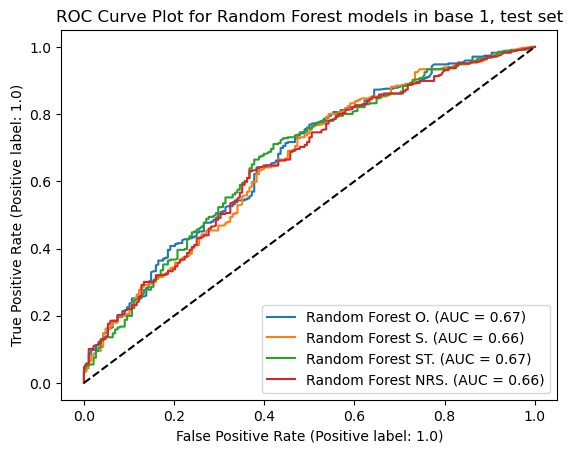

In [44]:
# Random Forest

fig, ax = plt.subplots()

metrics.plot_roc_curve( rf_optimal_model_o, x_test, y_test, ax = ax, name = 'Random Forest O.' )
metrics.plot_roc_curve( rf_optimal_model_s, x_test, y_test, ax = ax, name = 'Random Forest S.' )
metrics.plot_roc_curve( rf_optimal_model_st, x_test, y_test, ax = ax, name = 'Random Forest ST.' )
metrics.plot_roc_curve( rf_optimal_model_nrs, x_test, y_test, ax = ax, name = 'Random Forest NRS.' )

plt.plot( [ 0, 1 ], [ 0, 1 ], 'k--' )

ax.set_title( 'ROC Curve Plot for Random Forest models in base 1, test set')
ax.legend( loc = 'lower right' )

plt.savefig( r'..\..\..\output\ejecucion_1\plots\base1\b1_ci_roc_curve_rf_test.jpg', dpi = 300, bbox_inches = 'tight' )

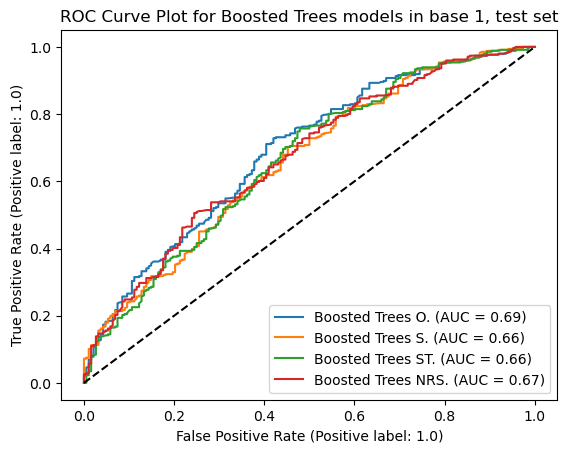

In [45]:
# Boosted Trees

fig, ax = plt.subplots()

metrics.plot_roc_curve( xgb_optimal_model_o, x_test, y_test, ax = ax, name = 'Boosted Trees O.' )
metrics.plot_roc_curve( xgb_optimal_model_s, x_test, y_test, ax = ax, name = 'Boosted Trees S.' )
metrics.plot_roc_curve( xgb_optimal_model_st, x_test, y_test, ax = ax, name = 'Boosted Trees ST.' )
metrics.plot_roc_curve( xgb_optimal_model_nrs, x_test, y_test, ax = ax, name = 'Boosted Trees NRS.' )

plt.plot( [ 0, 1 ], [ 0, 1 ], 'k--' )

ax.set_title( 'ROC Curve Plot for Boosted Trees models in base 1, test set')
ax.legend( loc = 'lower right' )

plt.savefig( r'..\..\..\output\ejecucion_1\plots\base1\b1_ci_roc_curve_xgb_test.jpg', dpi = 300, bbox_inches = 'tight' )

### 10.2. Training set

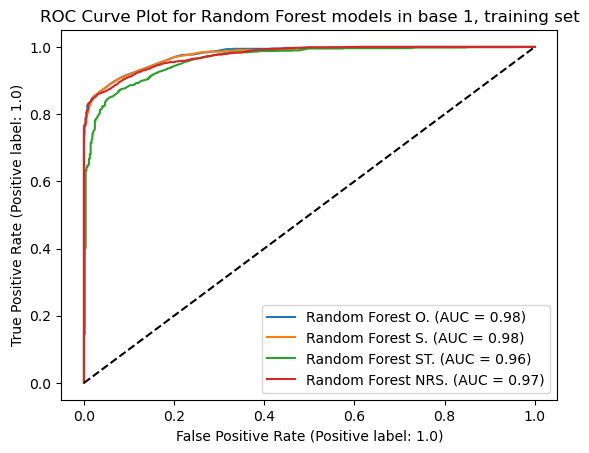

In [46]:
# Random Forest

fig, ax = plt.subplots()

metrics.plot_roc_curve( rf_optimal_model_o, x_train, y_train, ax = ax, name = 'Random Forest O.' )
metrics.plot_roc_curve( rf_optimal_model_s, x_train, y_train, ax = ax, name = 'Random Forest S.' )
metrics.plot_roc_curve( rf_optimal_model_st, x_train, y_train, ax = ax, name = 'Random Forest ST.' )
metrics.plot_roc_curve( rf_optimal_model_nrs, x_train, y_train, ax = ax, name = 'Random Forest NRS.' )

plt.plot( [ 0, 1 ], [ 0, 1 ], 'k--' )

ax.set_title( 'ROC Curve Plot for Random Forest models in base 1, training set')
ax.legend( loc = 'lower right' )

plt.savefig( r'..\..\..\output\ejecucion_1\plots\base1\b1_ci_roc_curve_rf_training.jpg', dpi = 300, bbox_inches = 'tight' )

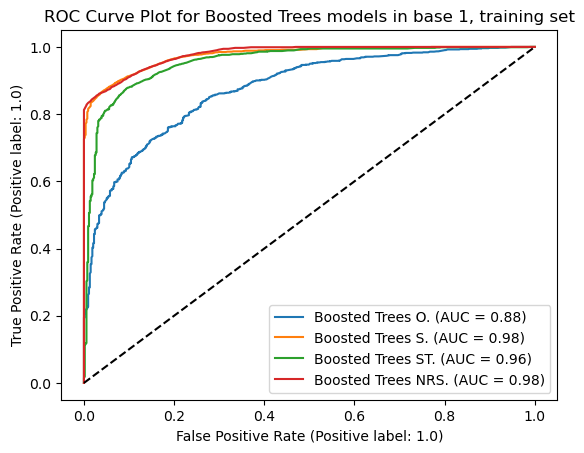

In [47]:
# Boosted Trees

fig, ax = plt.subplots()

metrics.plot_roc_curve( xgb_optimal_model_o, x_train, y_train, ax = ax, name = 'Boosted Trees O.' )
metrics.plot_roc_curve( xgb_optimal_model_s, x_train, y_train, ax = ax, name = 'Boosted Trees S.' )
metrics.plot_roc_curve( xgb_optimal_model_st, x_train, y_train, ax = ax, name = 'Boosted Trees ST.' )
metrics.plot_roc_curve( xgb_optimal_model_nrs, x_train, y_train, ax = ax, name = 'Boosted Trees NRS.' )

plt.plot( [ 0, 1 ], [ 0, 1 ], 'k--' )

ax.set_title( 'ROC Curve Plot for Boosted Trees models in base 1, training set')
ax.legend( loc = 'lower right' )

plt.savefig( r'..\..\..\output\ejecucion_1\plots\base1\b1_ci_roc_curve_xgb_training.jpg', dpi = 300, bbox_inches = 'tight' )

## 11. Save models

In [48]:
joblib.dump( lg_model_o, r'..\..\..\output\ejecucion_1\models\base1\b1_ci_lg_model_ojoblib' )
joblib.dump( lg_model_s, r'..\..\..\output\ejecucion_1\models\base1\b1_ci_lg_model_s.joblib' )
joblib.dump( lg_model_st, r'..\..\..\output\ejecucion_1\models\base1\b1_ci_lg_model_st.joblib' )
joblib.dump( lg_model_nrs, r'..\..\..\output\ejecucion_1\models\base1\b1_ci_lg_model_nrs.joblib' )

joblib.dump( lasso_model_o, r'..\..\..\output\ejecucion_1\models\base1\b1_ci_lasso_model_o.joblib' )
joblib.dump( lasso_model_s, r'..\..\..\output\ejecucion_1\models\base1\b1_ci_lasso_model_s.joblib' )
joblib.dump( lasso_model_st, r'..\..\..\output\ejecucion_1\models\base1\b1_ci_lasso_model_st.joblib' )
joblib.dump( lasso_model_nrs, r'..\..\..\output\ejecucion_1\models\base1\b1_ci_lasso_model_nrs_1.joblib' )

joblib.dump( ridge_model_o, r'..\..\..\output\ejecucion_1\models\base1\b1_ci_ridge_model_o.joblib' )
joblib.dump( ridge_model_s, r'..\..\..\output\ejecucion_1\models\base1\b1_ci_ridge_model_s.joblib' )
joblib.dump( ridge_model_st, r'..\..\..\output\ejecucion_1\models\base1\b1_ci_ridge_model_st.joblib' )
joblib.dump( ridge_model_nrs, r'..\..\..\output\ejecucion_1\models\base1\b1_ci_ridge_model_nrs.joblib' )

joblib.dump( elasticnet_model_o, r'..\..\..\output\ejecucion_1\models\base1\b1_ci_elasticnet_model_o.joblib' )
joblib.dump( elasticnet_model_s, r'..\..\..\output\ejecucion_1\models\base1\b1_ci_elasticnet_model_s.joblib' )
joblib.dump( elasticnet_model_st, r'..\..\..\output\ejecucion_1\models\base1\b1_ci_elasticnet_model_st.joblib' )
joblib.dump( elasticnet_model_nrs, r'..\..\..\output\ejecucion_1\models\base1\b1_ci_elasticnet_model_nrs.joblib' )

joblib.dump( rf_optimal_model_o, r'..\..\..\output\ejecucion_1\models\base1\b1_ci_rf_o.joblib' )
joblib.dump( rf_optimal_model_s, r'..\..\..\output\ejecucion_1\models\base1\b1_ci_rf_s.joblib' )
joblib.dump( rf_optimal_model_st, r'..\..\..\output\ejecucion_1\models\base1\b1_ci_rf_st.joblib' )
joblib.dump( rf_optimal_model_nrs, r'..\..\..\output\ejecucion_1\models\base1\b1_ci_rf_nrs.joblib' )

joblib.dump( xgb_optimal_model_o, r'..\..\..\output\ejecucion_1\models\base1\b1_ci_xgb_o.joblib' )
joblib.dump( xgb_optimal_model_s, r'..\..\..\output\ejecucion_1\models\base1\b1_ci_xgb_s.joblib' )
joblib.dump( xgb_optimal_model_st, r'..\..\..\output\ejecucion_1\models\base1\b1_ci_xgb_st.joblib' )
joblib.dump( xgb_optimal_model_nrs, r'..\..\..\output\ejecucion_1\models\base1\b1_ci_xgb_nrs.joblib' )

['..\\..\\..\\output\\ejecucion_1\\models\\base1\\b1_ci_xgb_nrs.joblib']

## 13. Grid Search Results

In [49]:
# Store Grid Search Results for Random Forest
results_gs_rf_o    = pd.DataFrame( rf_search_o.cv_results_ )
results_gs_rf_s    = pd.DataFrame( rf_search_s.cv_results_ )
results_gs_rf_st   = pd.DataFrame( rf_search_st.cv_results_ )
results_gs_rf_nrs  = pd.DataFrame( rf_search_nrs.cv_results_ )

# Store Grid Search Results for Boosted Trees
results_gs_xgb_o   = pd.DataFrame( xgb_search_o.cv_results_ )
results_gs_xgb_s   = pd.DataFrame( xgb_search_s.cv_results_ )
results_gs_xgb_st  = pd.DataFrame( xgb_search_st.cv_results_ )
results_gs_xgb_nrs = pd.DataFrame( xgb_search_nrs.cv_results_ )

In [50]:
# Save Grid Search Results for Random Forest
results_gs_rf_o.to_excel( r'..\..\..\output\ejecucion_1\gridsearch_results\base1\b1_ci_results_gs_rf_o.xlsx' )
results_gs_rf_s.to_excel( r'..\..\..\output\ejecucion_1\gridsearch_results\base1\b1_ci_results_gs_rf_s.xlsx' )
results_gs_rf_st.to_excel( r'..\..\..\output\ejecucion_1\gridsearch_results\base1\b1_ci_results_gs_rf_st.xlsx' )
results_gs_rf_nrs.to_excel( r'..\..\..\output\ejecucion_1\gridsearch_results\base1\b1_ci_results_gs_rf_nrs.xlsx' )

# Save Grid Search Results for Boosted Trees
results_gs_xgb_o.to_excel( r'..\..\..\output\ejecucion_1\gridsearch_results\base1\b1_ci_results_gs_xgb_o.xlsx' )
results_gs_xgb_s.to_excel( r'..\..\..\output\ejecucion_1\gridsearch_results\base1\b1_ci_results_gs_xgb_s.xlsx' )
results_gs_xgb_st.to_excel( r'..\..\..\output\ejecucion_1\gridsearch_results\base1\b1_ci_results_gs_xgb_st.xlsx' )
results_gs_xgb_nrs.to_excel( r'..\..\..\output\ejecucion_1\gridsearch_results\base1\b1_ci_results_gs_xgb_nrs.xlsx' )

## 14. Features maps

In [51]:
# Random Forest (Original) 
fp_randomforest_o = pd.Series( rf_optimal_model_o.feature_importances_, index = pred_vars ).\
                    sort_values( ascending = False )

fp_randomforest_o = pd.DataFrame( fp_randomforest_o.head( 50 ) ).\
                                  reset_index().\
                                  rename( columns = { 'index': 'vars', 0: 'score' } )

In [52]:
# Random Forest (SMOTE)
fp_randomforest_s = pd.Series( rf_optimal_model_s.feature_importances_, index = pred_vars ).\
                    sort_values( ascending = False )

fp_randomforest_s = pd.DataFrame( fp_randomforest_s.head( 50 ) ).\
                                  reset_index().\
                                  rename( columns = { 'index': 'vars', 0: 'score' } )

In [53]:
# Random Forest (SMOTE Tomek)
fp_randomforest_st = pd.Series( rf_optimal_model_st.feature_importances_, index = pred_vars ).\
                     sort_values( ascending = False )

fp_randomforest_st = pd.DataFrame( fp_randomforest_st.head( 50 ) ).\
                                   reset_index().\
                                   rename( columns = { 'index': 'vars', 0: 'score' } )

In [54]:
# Random Forest (NRS)
fp_randomforest_nrs = pd.Series( rf_optimal_model_nrs.feature_importances_, index = pred_vars ).\
                      sort_values( ascending = False )

fp_randomforest_nrs = pd.DataFrame( fp_randomforest_nrs.head( 50 ) ).\
                                    reset_index().\
                                    rename( columns = { 'index': 'vars', 0: 'score' } )

In [55]:
# Boosted Trees (Original)
fp_xgboost_o = pd.Series( xgb_optimal_model_o.feature_importances_, index = pred_vars ).\
           sort_values( ascending = False )

fp_xgboost_o = pd.DataFrame( fp_xgboost_o.head( 50 ) ).\
                             reset_index().\
                             rename( columns = { 'index': 'vars', 0: 'score' } )

In [56]:
# Boosted Trees (SMOTE)
fp_xgboost_s = pd.Series( xgb_optimal_model_s.feature_importances_, index = pred_vars ).\
               sort_values( ascending = False )

fp_xgboost_s = pd.DataFrame( fp_xgboost_s.head( 50 ) ).\
                             reset_index().\
                             rename( columns = { 'index': 'vars', 0: 'score' } )

In [57]:
# Boosted Trees (SMOTE Tomek)
fp_xgboost_st = pd.Series( xgb_optimal_model_st.feature_importances_, index = pred_vars ).\
                sort_values( ascending = False )

fp_xgboost_st = pd.DataFrame( fp_xgboost_st.head( 50 ) ).\
                              reset_index().\
                              rename( columns = { 'index': 'vars', 0: 'score' } )

In [58]:
# Boosted Trees (NRS)
fp_xgboost_nrs = pd.Series( xgb_optimal_model_nrs.feature_importances_, index = pred_vars ).\
                 sort_values( ascending = False )

fp_xgboost_nrs = pd.DataFrame( fp_xgboost_nrs.head( 50 ) ).\
                               reset_index().\
                               rename( columns = { 'index': 'vars', 0: 'score' } )

## 15. Export results

In [59]:
# Variables Random Forest

fp_randomforest_o.to_excel( r'..\..\..\output\ejecucion_1\results\base1\base1_ci_rf_o.xlsx' )
fp_randomforest_s.to_excel( r'..\..\..\output\ejecucion_1\results\base1\base1_ci_rf_s.xlsx' )
fp_randomforest_st.to_excel( r'..\..\..\output\ejecucion_1\results\base1\base1_ci_rf_st.xlsx' )
fp_randomforest_nrs.to_excel( r'..\..\..\output\ejecucion_1\results\base1\base1_ci_rf_nrs.xlsx' )

In [60]:
# Variables Boosted Trees

fp_xgboost_o.to_excel( r'..\..\..\output\ejecucion_1\results\base1\base1_ci_xgb_o.xlsx' )
fp_xgboost_s.to_excel( r'..\..\..\output\ejecucion_1\results\base1\base1_ci_xgb_s.xlsx' )
fp_xgboost_st.to_excel( r'..\..\..\output\ejecucion_1\results\base1\base1_ci_xgb_st.xlsx' )
fp_xgboost_nrs.to_excel( r'..\..\..\output\ejecucion_1\results\base1\base1_ci_xgb_nrs.xlsx' )